# MEMO 3: Terrain reflections at Marjum Pass

In this memo, we simulate terrain reflections for an antenna suspended at a height of 100 m near Marjum Pass, UT.

In [2]:
import numpy as np
import matplotlib.pylab as plt
import PIL.Image
import tqdm
from scipy.interpolate import RectBivariateSpline

%matplotlib widget

In [4]:
filename = 'marjum_tiffs/USGS_13_n40w114.tif' # Marjum Pass, UT
data = np.array(PIL.Image.open(filename))
xmin,ymin = 6200, 8000
width = 400
data = data[ymin:ymin+width, xmin:xmin+width] # crop to region
res = 10 # m per px
ys,xs = np.indices(data.shape)

/usr/lib/python3/dist-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (116899344 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [5]:
# Site info
npz = np.load('Site1.npz')
x0,y0,z0 = npz['xyz']
x0 = int(x0 + 5000 - xmin) # pixel location of antenna
y0 = int(y0 + 7000 - ymin) # pixel location of antenna
ths = npz['ths']
angs = npz['horizon_angles']

In [6]:
# Compute which terrain pixels are visible
ys,xs = np.indices(data.shape)
r = np.sqrt((xs-x0)**2 + (ys-y0)**2)
hor_ang = np.arctan2(data - z0, r * res)
hor_interp = RectBivariateSpline(ys[:,0], xs[0], hor_ang)
r_grid = np.linspace(0, r.max(), 800)
th_grid = np.linspace(-np.pi, np.pi, 800)
rth_ang = np.empty((r_grid.size, th_grid.size), dtype=float)
for cnt,th in enumerate(th_grid):
    _ys,_xs = y0-r_grid * np.cos(th), x0+r_grid * np.sin(th)
    _angs = hor_interp(_ys,_xs, grid=False)
    rth_ang[:,cnt] = np.maximum.accumulate(_angs)
rth_interp = RectBivariateSpline(r_grid, th_grid, rth_ang)

ths = np.arctan2(xs-x0, y0-ys)
hor_thresh = rth_interp(r.flat, ths.flat, grid=False)
hor_thresh.shape = r.shape
visible = np.where(hor_ang >= hor_thresh - 0.01*np.abs(hor_thresh), 1., 0)

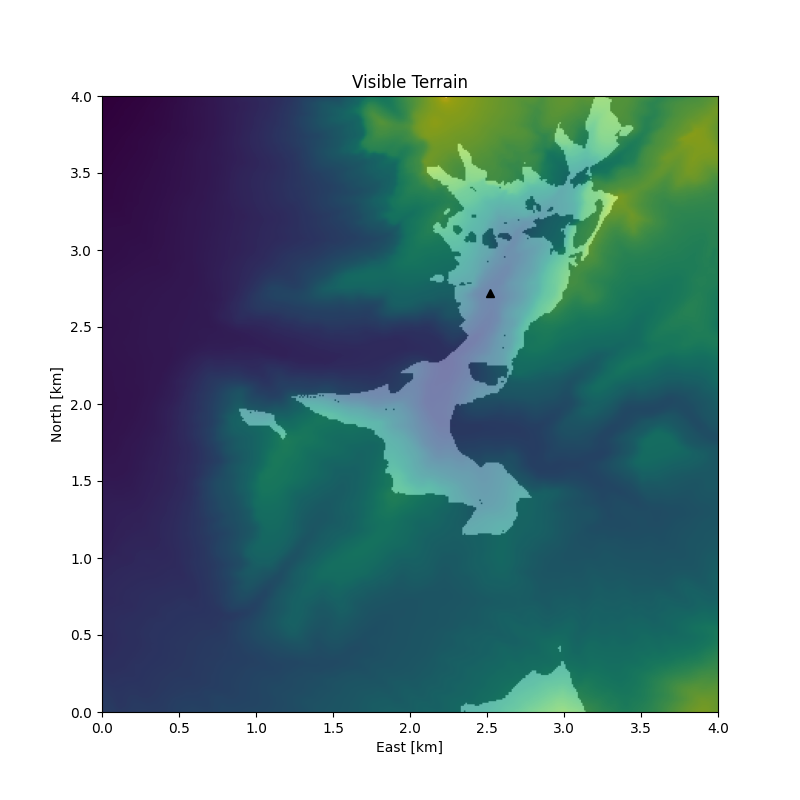

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(data, extent=(0,width*res/1e3,0,width*res/1e3))
plt.imshow(visible, extent=(0,width*res/1e3,0,width*res/1e3), cmap='gray', alpha=0.3)
plt.plot([x0*res/1e3], [(width-y0)*res/1e3], 'k^')
plt.title('Visible Terrain')
plt.xlabel('East [km]')
_ = plt.ylabel('North [km]')

## Dispersion Relation

We can derive the dispersion relation as a function of conductivity $\sigma$ from Maxwell's equations,
using that $\vec J = \sigma \vec E$, and that $\vec E=\vec E_0 e^{i(\vec k\cdot\vec x - \omega t)}$

\begin{align}
kE &= \frac{\omega B}{c}\\
\frac{kc}{\omega}E &= B\\
-ikB &= \left(\frac{4\pi\sigma}{c}-\frac{i\omega}{c}\right)E\\
-i\frac{k^2c^2}{\omega^2}E &= \left(\frac{4\pi\sigma}{\omega}-i\right)E\\
\eta^2&=\frac{k^2c^2}{\omega^2} = 1+i\frac{4\pi\sigma}{\omega}
\end{align}

This final equation gives us the (complex) index of refraction $\eta$ in terms of conductivity and frequency.
Discontinuities in the index of refraction going from $\eta_0\rightarrow\eta$ cause reflections, with a power magnitude given by
\begin{equation}
R = \left|\frac{\eta_0-\eta}{\eta_0+\eta}\right|^2
\end{equation}

If we assume $\eta_0=1$, we just need soil/rock conductivity to calculate relection coefficients.

*Applied Geophysics* (Telford, Geldart, Sheriff, 1976) tabulates various resisitivities:
<div>
<img src="resistivities_table4.png" width="500"/>
</div>

Marjum pass is extensively limestone and shale (predominantly CaCO$_3$).

Our expression for $\eta$ is in Gaussian units, so we need to convert $r$ to $\sigma$ with the appropriate units
\begin{equation}
\sigma \left[\frac1{\rm s}\right]= \frac{1}{r \left[\Omega~{\rm m}\right]
        \cdot1.113\cdot10^{-12} \left[\frac{{\rm s}/{\rm cm}}\Omega\right]\cdot100\left[\frac{\rm cm}{\rm m}\right]}
\end{equation}

For comparison, we also have this table of conductivities (which I believe comes from Supandi 2021):
<div>
<img src="resistivity_table1.png" width="500"/>
</div>

In [12]:
def reflection_coefficient(freqs, resistivity_ohm_m, eta_0=1):
    omega = 2 * np.pi * freqs # Hz
    conductivity = 1 / (resistivity_ohm_m * 1.113e-12 * 100)
    eta = (1 + 1j * 4 * np.pi * conductivity / omega)**0.5
    R = np.abs((eta_0 - eta) / (eta_0 + eta))**2
    return R
    
#resistivity_ohm_m = 2e12 # Ohm m, calcite, Telford et al. 1976
#resistivity_ohm_m = 50 # Ohm m, lower bound limestone, Telford et al. 1976
resistivity_ohm_m = 3e2 # Ohm m, middle of the road?
#resistivity_ohm_m = 1e3 # Ohm m, typical shale, Telford et al. 1976
#resistivity_ohm_m = 1e7 # Ohm m, upper bound limestone, Telford et al. 1976
f0 = 100e6 # Hz
R = reflection_coefficient(f0, resistivity_ohm_m)
print(R)

0.019892657739867935


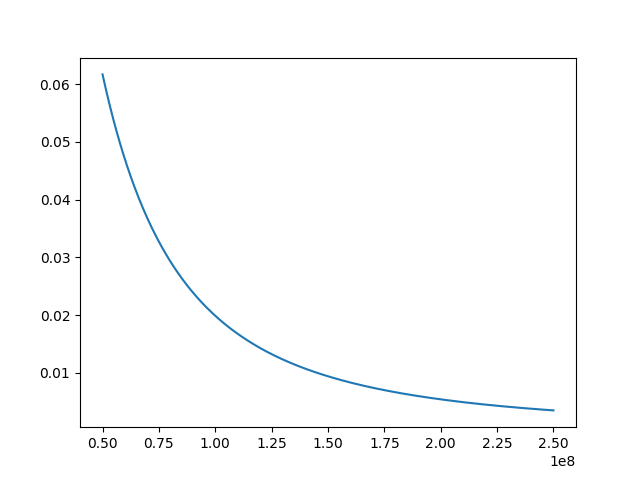

In [13]:
plt.figure()
freqs = np.linspace(50e6, 250e6, 512)
plt.plot(freqs, reflection_coefficient(freqs, resistivity_ohm_m))

In [88]:
#albedo = 0.1
albedo = R
beam_fwd_dB = 5 # dB, HERA Vivaldi
beam_bkd_dB = 0 # dB, HERA Vivaldi
beam_fwd_gain = 10**(-beam_fwd_dB/10)
beam_bkd_gain = 10**(-beam_bkd_dB/10)
lam = 3e8 / f0 # m
aperture = lam**2 # m^2
coh_px_area = res**2
modes_per_px = res**2 / lam**2
inc_px_area = np.sqrt(modes_per_px) * lam**2

T_sync = 180 * (f0 / 180e6)**-2.5
T_pnt = 3 * (f0 / 180e6)**-1.8
T = T_sync * (res * r.clip(1,np.Inf)/lam)**-3 + T_pnt
Tflat = T_sync * (lam * r.clip(1,np.Inf)/lam)**-3 + T_pnt
len_ns = 3e8 * 1e-9 # m

# Add up actual terrain profile
d = np.sqrt((res*r)**2 + (z0-data)**2)
#dflat = (res*r).clip(lam, np.Inf)
dflat = (lam*r).clip(lam, np.Inf)
delay = (d + z0-data) / len_ns
print(delay.min(), delay.max())
rand_phs = np.exp(2j*np.pi*np.random.uniform(size=delay.shape))
wgts_coh = np.where(visible, np.sqrt(T*coh_px_area * beam_bkd_gain * albedo)/np.sqrt(2*np.pi*d**2), 0)
wgts_inc = np.where(visible, np.sqrt(T*inc_px_area * beam_bkd_gain * albedo)/np.sqrt(2*np.pi*d**2), 0)

hist = {}
#bin_cen = np.linspace(0, 14000, 512)
bin_cen = np.linspace(0, 3000, 512)
#bin_cen = np.linspace(0, 30000, 3000)
#hist['coh'], bins = np.histogram(delay, weights=wgts_coh, bins=bin_cen)
#hist['inc1'], bins = np.histogram(delay, weights=wgts_inc**2, bins=bin_cen)
#hist['inc1'] = np.sqrt(hist['inc1'])
hist['inc'], bins = np.histogram(delay, weights=wgts_inc*rand_phs, bins=bin_cen)
    
# Add up flat terrain profile
wgts_flat_inc = np.sqrt(Tflat * lam**2 * beam_bkd_gain * albedo)/np.sqrt(2*np.pi*dflat**2)
hist['flat'], bins = np.histogram(dflat / len_ns, weights=wgts_flat_inc*rand_phs, bins=bin_cen)

# Add in direct sky contribution
for k in hist.keys():
    hist[k][0] = np.sqrt(T_sync * beam_fwd_gain * aperture)

330.9345313735737 12719.5544152025


<IPython.core.display.Javascript object>


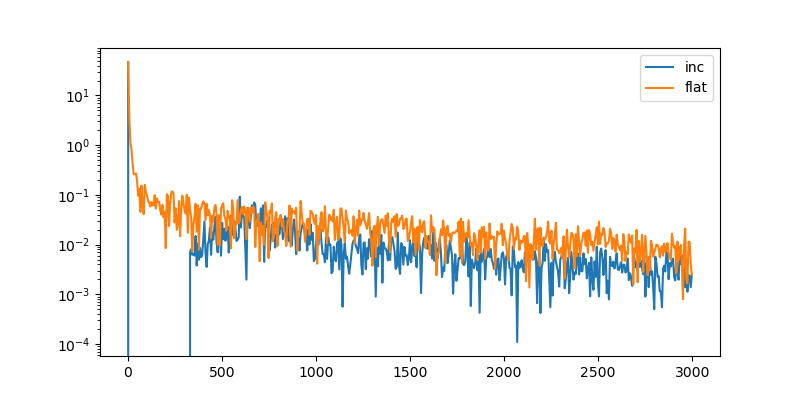

In [89]:
bin_cen = 0.5 * (bins[:-1] + bins[1:])
plt.figure(figsize=(8,4))
for k in hist.keys():
    plt.semilogy(bin_cen, np.abs(hist[k]), label=k)
plt.legend()

In [92]:
# Voltage domain
fq = np.fft.fftfreq(bin_cen.size, np.median(np.diff(bin_cen)))
tau = np.fft.fftfreq(fq.size, np.median(np.diff(fq)))
V = {}
Vt = {}
for k in hist.keys():
    v = np.fft.ifft(hist[k])
    V[k] = np.abs(v)**2
    #Vt[k] = np.fft.fft(win*V[k]) # has wrap-around problems
    #Vt[k] = np.fft.fft(V[k]) # has wrap-around problems
    Vt[k] = np.convolve(hist[k], hist[k][::-1])
    pk = np.argmax(np.abs(Vt[k]))
    Vt[k] = np.fft.fftshift(Vt[k][pk-fq.size//2:pk+fq.size//2+1]/Vt[k][pk])
np.savez('delay_profile.npz', delay=tau, **Vt)

<IPython.core.display.Javascript object>


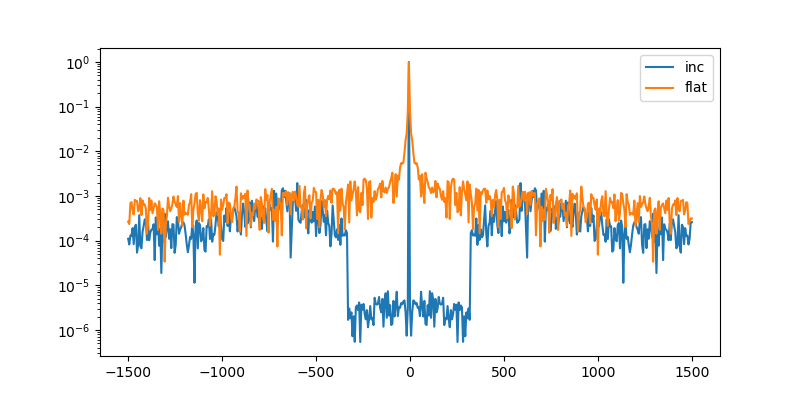

In [91]:
plt.figure(figsize=(8,4))
for k in Vt.keys():
    plt.semilogy(np.fft.fftshift(tau), np.abs(np.fft.fftshift(Vt[k])), label=k)
    #plt.semilogy(np.abs(np.convolve(hist[k], hist[k][::-1])), label=k)
plt.legend()